<a href="https://colab.research.google.com/github/eroolpal/pythoncodes/blob/master/Earthquake_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#to access Kaggle datasets
!pip install kaggle

#math operations
!pip install numpy==1.15.0

#machine learning
!pip install catboost


    100% |████████████████████████████████| 13.9MB 2.1MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3


    100% |████████████████████████████████| 60.6MB 547kB/s 


In [0]:
#data preprocessing
import pandas as pd

#math operations
import numpy as np

#machine learning
from catboost import CatBoostRegressor, Pool

#data scaling
from sklearn.preprocessing import StandardScaler

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#support Vector machine model
from sklearn.svm import NuSVR, SVR

#Kernal Ridge model
from sklearn.kernel_ridge import KernelRidge

#data Visualization
import matplotlib.pyplot as plt

In [9]:
#Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded=files.upload()

#Then move kaggle.json into the folder where the API expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [10]:
#list competitions
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2910           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11214            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4335           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         40           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2849           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [12]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-prediction





  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 27.6MB/s]
 99% 240M/242M [00:01<00:00, 191MB/s]
100% 242M/242M [00:01<00:00, 183MB/s]
100% 2.02G/2.03G [00:36<00:00, 15.8MB/s]
100% 2.03G/2.03G [00:36<00:00, 60.0MB/s]


In [13]:
#unzip will take about 5 mins (its big)
!unzip train.csv.zip
!ls


Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


Explarotary data analysis


In [0]:
#extracting training data into a dataframe for further manipulation


train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [16]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


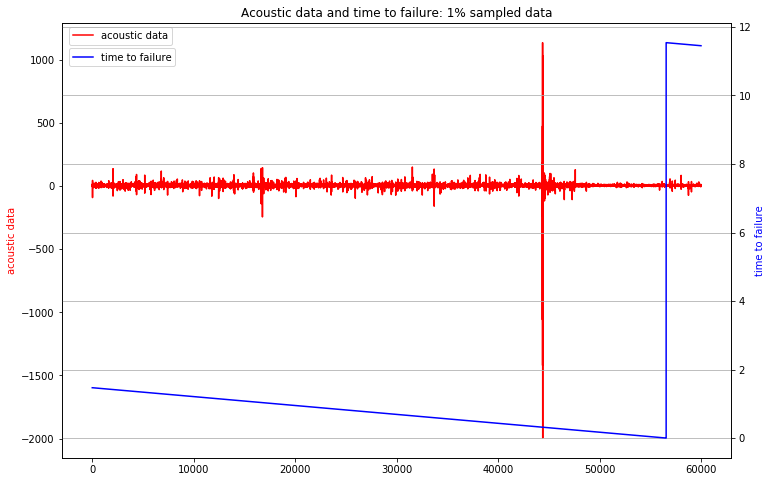

In [15]:

#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:

# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [18]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [20]:

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='RMSE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'RMSE': 2.218547389041747}}